In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Use CPU only to avoid GPU-related import errors
device = torch.device("cpu")

# ------------------------
# Data Preprocessing
# ------------------------

# Load orientation data (path provided by user)
ori_path = "DC3_final_530km_3_month_with_slew_15sbins_EarthLocal.ori"
ori_df = pd.read_csv(
    ori_path,
    delim_whitespace=True,
    skiprows=1,
    header=None,
    names=["prefix", "timestamp", "x_lat", "x_lon", "z_lat", "z_lon", "altitude_km", "Earth_lat", "Earth_lon"]
)
ori_df = ori_df.drop(columns=["prefix"])
ori_df["timestamp"] = pd.to_datetime(ori_df["timestamp"], unit='s')

# Load detector data
time_array = np.load("time_array.npy")
rates = np.squeeze(np.load("total_rates.npy"))
time_series = pd.to_datetime(time_array, unit='s')
rates_df = pd.DataFrame(rates, columns=[f"detector_{i+1}" for i in range(rates.shape[1])])
rates_df["timestamp"] = time_series



C:\Users\Admin\AppData\Local\Temp\ipykernel_18384\3250813714.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ori_df = pd.read_csv(


(5761, 7)
(2640, 7)


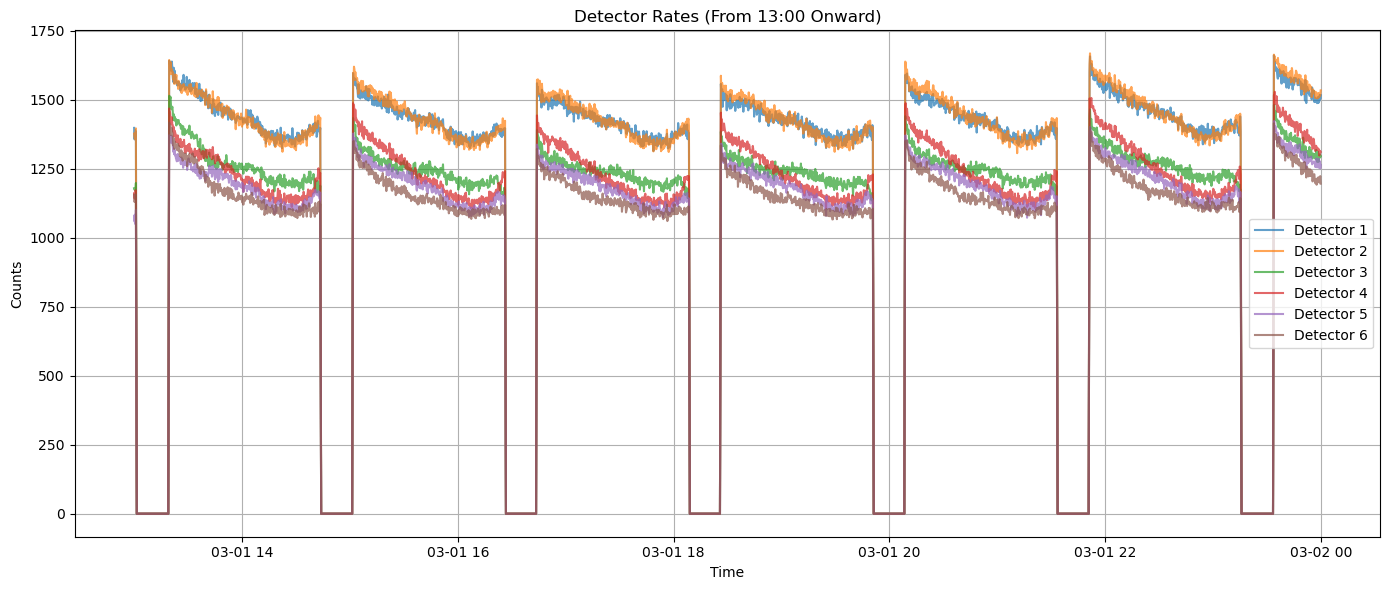

In [2]:
# Filter all days from 13:00 to 00:00
print(rates_df.shape)
rates_df = rates_df[rates_df["timestamp"].dt.hour >= 13]
print(rates_df.shape)
# Plot all 6 detectors after filtering to 13:00 onward
plt.figure(figsize=(14, 6))
for i in range(1, 7):
    plt.plot(rates_df["timestamp"], rates_df[f"detector_{i}"], label=f"Detector {i}", alpha=0.7)

plt.title("Detector Rates (From 13:00 Onward)")
plt.xlabel("Time")
plt.ylabel("Counts")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ori_df = ori_df.dropna(subset=["timestamp"])

In [3]:
# Merge orientation with detector data
merged_df = pd.merge_asof(
    rates_df.sort_values("timestamp"),
    ori_df.sort_values("timestamp"),
    on="timestamp"
).dropna()

In [4]:
merged_df["hour"] = merged_df["timestamp"].dt.hour + merged_df["timestamp"].dt.minute / 60
#merged_df["sin_time"] = np.sin(2 * np.pi * merged_df["hour"] / 24)
##erged_df["cos_time"] = np.cos(2 * np.pi * merged_df["hour"] / 24)


In [5]:
# Parameters
WINDOW_SIZE = 2
EPOCHS = 200
learning_rate= 1e-3#5*1e-5
epochs_no_improve = 10
early_stopping_patience = 10

def create_windowed_data(X, y, window_size):
    X_seq, y_seq = [], []
    for i in range(window_size, len(X)):
        X_seq.append(X[i - window_size:i].flatten())  # flatten the window
        y_seq.append(y[i])  # predict current target
    return np.array(X_seq), np.array(y_seq)

In [6]:
# Extract features and targets again from merged_df
orientation_features = ["x_lat", "x_lon", "z_lat", "z_lon", "altitude_km", "Earth_lat", "Earth_lon"]
#time_features = ["sin_time", "cos_time"]
feature_cols = orientation_features# + time_features
target_cols = [col for col in merged_df.columns if col.startswith("detector_")]

X_all = merged_df[feature_cols].values
y_all = merged_df[target_cols].values

# Normalize features
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

y_scaler = StandardScaler()
y_all_scaled = y_scaler.fit_transform(y_all)

# Create windowed sequences again with scaled y
X_seq, y_seq = create_windowed_data(X_all_scaled, y_all_scaled, WINDOW_SIZE)

In [7]:
# Create windowed sequences again with scaled y
X_seq, y_seq = create_windowed_data(X_all_scaled, y_all_scaled, WINDOW_SIZE)

# Split again
split_index = int(len(X_seq) * 0.7)
X_train_seq, X_test_seq = X_seq[:split_index], X_seq[split_index:]
y_train_seq, y_test_seq = y_seq[:split_index], y_seq[split_index:]



In [8]:
# Dataset and model
class WindowedDetectorDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(WindowedDetectorDataset(X_train_seq, y_train_seq), batch_size=64, shuffle=True)
test_loader = DataLoader(WindowedDetectorDataset(X_test_seq, y_test_seq), batch_size=64, shuffle=False)

class FeedforwardWindowed(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.mu = nn.Linear(32, output_dim)
        self.log_sigma = nn.Linear(32, output_dim)

    def forward(self, x):
        h = self.model(x)
        mu = self.mu(h)
        sigma = torch.exp(self.log_sigma(h))
        #sigma = torch.clamp(sigma, min=1e-3)
        return mu, sigma

# Loss and training
def gaussian_nll(y_true, mu, sigma):
    return torch.mean(0.5 * torch.log(2 * torch.pi * sigma ** 2) + 0.5 * ((y_true - mu) ** 2) / (sigma ** 2))

In [9]:
# Redefine datasets and loaders
train_loader = DataLoader(WindowedDetectorDataset(X_train_seq, y_train_seq), batch_size=64, shuffle=True)
test_loader = DataLoader(WindowedDetectorDataset(X_test_seq, y_test_seq), batch_size=64, shuffle=False)

In [10]:
# Retrain the model with same architecture
model = FeedforwardWindowed(X_train_seq.shape[1], y_train_seq.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
best_loss = float('inf')
best_model_path = "best_model.pt"

losses = []
for epoch in range(EPOCHS):
    model.train()
    epoch_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        mu, sigma = model(xb)
        sigma = torch.clamp(sigma, min=1e-3)
        loss = gaussian_nll(yb, mu, sigma)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    
    mean_loss = np.mean(epoch_losses)
    losses.append(mean_loss)
    print(f"Epoch {epoch+1}: Loss = {mean_loss:.4f}")

    # Early stopping logic
    if mean_loss < best_loss - 1e-4:  # a small delta to avoid noise
        best_loss = mean_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print("Saved best model.")

# Load best model after training
model.load_state_dict(torch.load(best_model_path))

Epoch 1: Loss = 1.2086
Saved best model.
Epoch 2: Loss = 0.3519
Saved best model.
Epoch 3: Loss = -0.6086
Saved best model.
Epoch 4: Loss = -0.9420
Saved best model.
Epoch 5: Loss = -1.1021
Saved best model.
Epoch 6: Loss = -1.2475
Saved best model.
Epoch 7: Loss = -1.3073
Saved best model.
Epoch 8: Loss = -1.3509
Saved best model.
Epoch 9: Loss = -1.3919
Saved best model.
Epoch 10: Loss = -1.4105
Saved best model.
Epoch 11: Loss = -1.4418
Saved best model.
Epoch 12: Loss = -1.4961
Saved best model.
Epoch 13: Loss = -1.4819
Epoch 14: Loss = -1.5221
Saved best model.
Epoch 15: Loss = -1.5019
Epoch 16: Loss = -1.5671
Saved best model.
Epoch 17: Loss = -1.6031
Saved best model.
Epoch 18: Loss = -1.5669
Epoch 19: Loss = -1.6024
Epoch 20: Loss = -1.6574
Saved best model.
Epoch 21: Loss = -1.6390
Epoch 22: Loss = -1.6779
Saved best model.
Epoch 23: Loss = -1.6919
Saved best model.
Epoch 24: Loss = -1.6734
Epoch 25: Loss = -1.6834
Epoch 26: Loss = -1.7087
Saved best model.
Epoch 27: Loss = -1

<All keys matched successfully>

In [12]:
# Evaluate
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
    mu_pred, sigma_pred = model(X_test_tensor)
    mu_pred = mu_pred.cpu().numpy()
    sigma_pred = sigma_pred.cpu().numpy()

# Invert scaling of predictions and targets
mu_pred_inv = y_scaler.inverse_transform(mu_pred)
y_test_inv = y_scaler.inverse_transform(y_test_seq)
sigma_pred_inv = sigma_pred * y_scaler.scale_  # approximate inverse scaling

# Compute MSE
mse = mean_squared_error(y_test_inv, mu_pred_inv)
print(f"\nWindowed MSE on test (30% holdout, normalized target): {mse:.4f}")




Windowed MSE on test (30% holdout, normalized target): 6720.3897


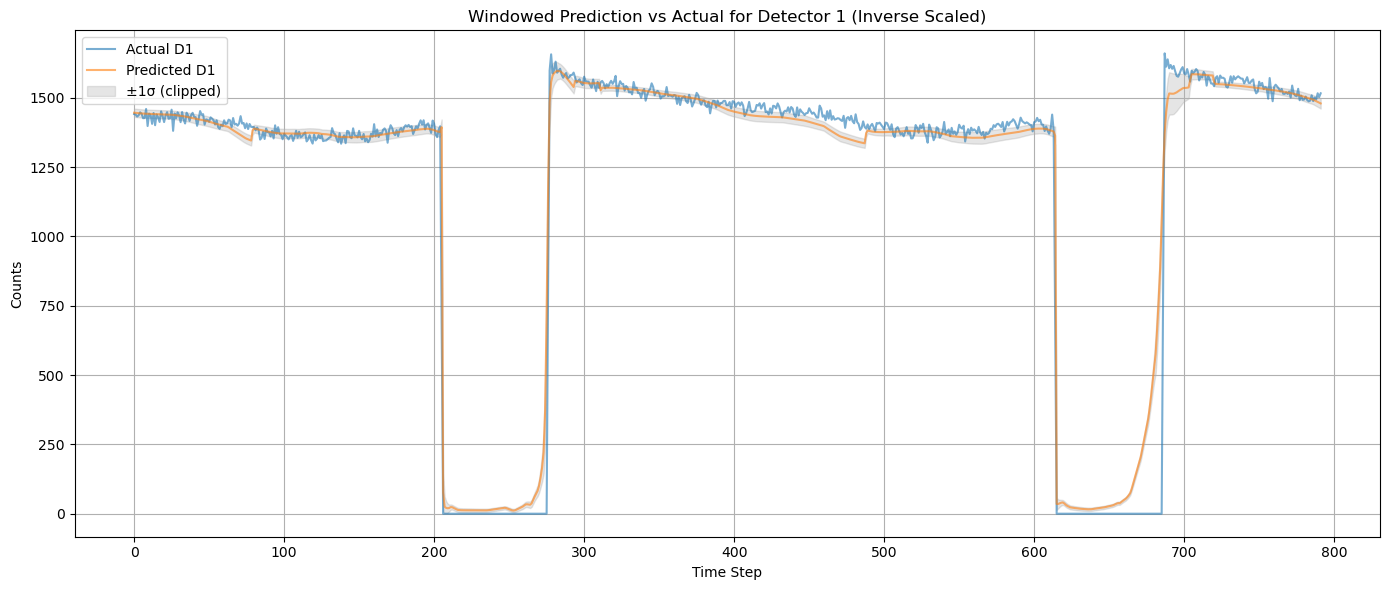

In [13]:
# Plot predictions for Detector 1

x_range = np.arange(len(mu_pred_inv))
plt.figure(figsize=(14, 6))
plt.plot(x_range, y_test_inv[:, 0], label="Actual D1", alpha=0.6)
plt.plot(x_range, mu_pred_inv[:, 0], label="Predicted D1", alpha=0.6)
lower_bound = np.clip(mu_pred_inv[:, 0] - sigma_pred_inv[:, 0], a_min=0, a_max=2000)
upper_bound = np.clip(mu_pred_inv[:, 0] + sigma_pred_inv[:, 0], a_min=0, a_max=2000)

plt.fill_between(
    x_range,
    lower_bound,
    upper_bound,
    color='gray', alpha=0.2, label="±1σ (clipped)"
)
plt.title("Windowed Prediction vs Actual for Detector 1 (Inverse Scaled)")
plt.xlabel("Time Step")
plt.ylabel("Counts")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
# window size 2

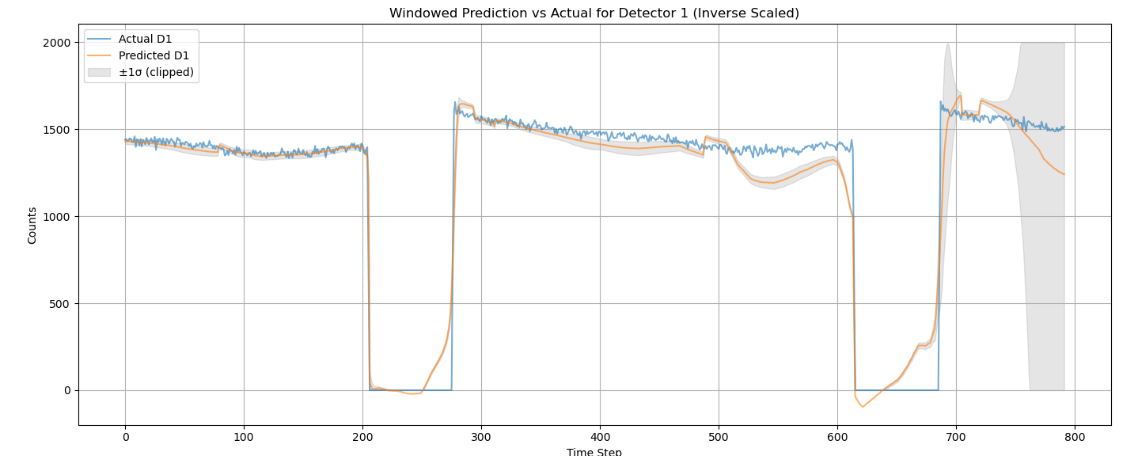